# Assignment 4:  Gendered Directions in Embeddings

In [1]:
import numpy as np
from urllib.request import urlopen
from tqdm import tqdm
import os.path
import time

class AlignedEmbeddingLoader(object):
  """This data loader will download an aligned fasttext embedding given a two letter language code.
  More information ca be found at https://fasttext.cc/docs/en/aligned-vectors.html ."""
  def __init__(self, lang='en'):
    """Data loader"""
    self._dataurl = "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.%s.align.vec" % lang
    cachefile = "cache_%s.npz" % lang
    if os.path.exists(cachefile):
      print("Loading cached data...", end="")
      t = time.time()
      data = np.load(cachefile)
      self.idx2token_ = list(data['idx2token'])
      self.vectors_ = data['vectors']
      print("done (%isec)" % (time.time()-t), flush=True)
    else:
      with urlopen(self._dataurl) as remote_file:
        get_decoded_line = lambda file: file.readline().decode('utf-8')
        self.n_tokens, self.n_dim = [int(n) for n in get_decoded_line(remote_file).split()]
        self.idx2token_ = list()
        self.vectors_ = np.zeros((self.n_tokens, self.n_dim), dtype=np.float32)
        for n in tqdm(range(self.vectors_.shape[0]), desc="Downloading and parsing vectors"):
          textline = get_decoded_line(remote_file)
          linedata = textline.split(' ')
          self.idx2token_.append(linedata[0])
          self.vectors_[n, :] = np.asarray(linedata[1:], dtype=np.float32)
      np.savez(cachefile, vectors=self.vectors_, idx2token=self.idx2token_)
    self.token2idx_ = {token:i for i, token in enumerate(self.idx2token_)}

loaded_embedding = AlignedEmbeddingLoader('en')

!ls -l

Loading cached data...done (98sec)
total 5196212
-rw-r--r-- 1 root root 5320910082 Jun  2 16:41 cache_en.npz
drwxr-xr-x 1 root root       4096 May  6 13:44 sample_data


## Analyzer

In [2]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

class EmbeddingAnalyzer(object):
    def __init__(self, embedding):
        self.vectors_ = embedding.vectors_
        self.token2idx_ = embedding.token2idx_
        self.idx2token_ = embedding.idx2token_

    def __len__(self):
        """Gives the number of tokens in the embedding."""
        return len(self.token2idx_)

    def __getitem__(self, tokens):
        """Returns the vectors for a token or a list of tokens."""
        if type(tokens) == str:
            return self.vectors_[self.token2idx_[tokens]]
        else:
            vecs = []
            for token in tokens:
                vecs.append(self.vectors_[self.token2idx_[token]])
            return np.asarray(vecs)

    def __contains__(self, token):
        """Allows a user query if a tokens is in the embedding."""
        if token in self.token2idx_:
            return True

    def projection(self, direction, vectors):
        """The cosine similarity between a reference direction and a matrix of word vectors.
        direction:
        A vector
        vectors:
        A row matrix with word vectors"""
        if vectors.ndim == 1:
            return cosine_similarity(direction.reshape(1, -1), vectors.reshape(1, -1))
        else:
            return cosine_similarity(direction.reshape(1, -1), vectors)

    def simple_analogy(self, pair, query, k=5):
        """Simple/Classic word analogy as: man - woman = king - queen"""
        matches = []
        x = self.__getitem__(query) - self.__getitem__(pair[0]) + self.__getitem__(pair[1])
        distances = euclidean_distances(self.vectors_, x.reshape(1, -1)).ravel()
        for idx in np.argsort(distances)[:k]:
            matches.append(self.idx2token_[idx])
        return matches

    def similarity(self, token1, token2):
        """Returns the cosine similarity between two tokens."""
        return cosine_similarity(self.__getitem__(token1).reshape(1, -1), self.__getitem__(token2).reshape(1, -1)).ravel()

    def analogies(self, analogy_direction, tokens):
        """The more complex word analogy method"""
        pairs = []
        for x in tokens:
            scores = {}
            for y in [token for token in tokens if not token == x]:
                if np.linalg.norm(self.__getitem__(x) - self.__getitem__(y)) <= 1:
                    scores[(x, y)] = cosine_similarity(analogy_direction.reshape(1, -1), (self.__getitem__(x) - self.__getitem__(y)).reshape(1, -1)).item()
                else: 
                    scores[(x, y)] = 0
            best_scores = list(sorted(scores.items(), key=lambda item: item[1], reverse=True))
            if best_scores[0][1] != 0:
                pairs.append(best_scores[0][0])
        return pairs

analyzer = EmbeddingAnalyzer(loaded_embedding)

assert 'man' in analyzer
assert 'woman' in analyzer
assert 'kdjfsfhgkdsjfdh' not in analyzer

assert len(analyzer) > 100000

assert type(analyzer['man']) is np.ndarray
assert np.isclose(np.sum(analyzer['man']-analyzer['man']), 0)

## Word similarity

In [3]:
assert analyzer.similarity('cat', 'dog') >= analyzer.similarity('cat', 'cow')

## Word analogies


### Nouns

In [4]:
best_matches = analyzer.simple_analogy(('man', 'woman'), 'king', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'queen' in analyzer.simple_analogy(('man', 'woman'), 'king', k=5)

Matches (in order of similarity):
1 king
2 queen
3 princess
4 regnant
5 princesses


### Capitals

In [5]:
best_matches = analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'tokyo' in analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)

Matches (in order of similarity):
1 tokyo
2 japan
3 osaka
4 kyoto
5 tokyo 


### Adjectives

In [6]:
best_matches = analyzer.simple_analogy(('big', 'bigger'), 'small', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

Matches (in order of similarity):
1 smaller
2 larger
3 small
4 bigger
5 smalled


## Finding the genderedness of professions

In [7]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json') as remote_file:
  professions = {title: {'definitional': defi, 'stereotypical': ster} for title, defi, ster in json.load(remote_file)}
print("Loaded %i professions" % len(professions))

Loaded 320 professions


The projection of vectors for different professions in a gender direction:

In [8]:
assert type(analyzer[['man', 'woman', 'butcher']]) is np.ndarray
assert analyzer[['man', 'woman', 'butcher']].shape[0] == 3

assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['butcher']) > 0
assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['ballerina']) < 0

Create a woman-man direction:

In [9]:
direction = analyzer['man']-analyzer['woman']
titles = [title for title in professions.keys() if title in analyzer]
projection = analyzer.projection(direction, analyzer[titles])

The estimation of the gender direction can be improved by using several pairs: 

In [10]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
  definitional_pairs = [(m, f) for m, f in json.load(remote_file)]
definitional_pairs

[('woman', 'man'),
 ('girl', 'boy'),
 ('she', 'he'),
 ('mother', 'father'),
 ('daughter', 'son'),
 ('gal', 'guy'),
 ('female', 'male'),
 ('her', 'his'),
 ('herself', 'himself'),
 ('Mary', 'John')]

In [11]:
direction2 = np.zeros(analyzer['man'].shape)
for female, male in definitional_pairs:
  direction2 += analyzer[male.lower()]
  direction2 -= analyzer[female.lower()]

projection2 = analyzer.projection(direction2, analyzer[titles])

### Plot the relation between genderedness in the data and human annotation

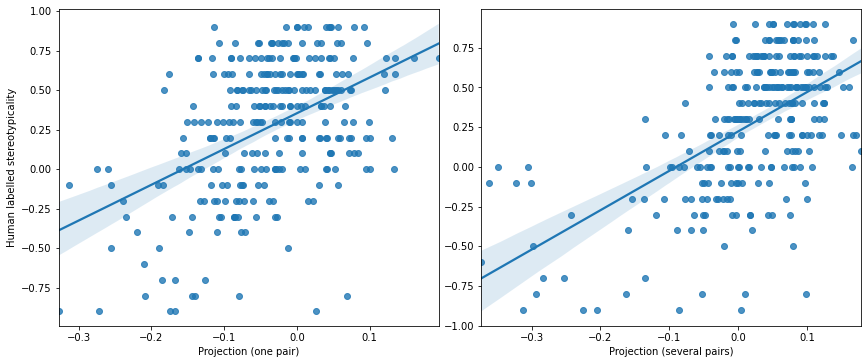

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
stereotypicality = [professions[title]['stereotypical'] for title in titles]
sns.regplot(x=projection, y=stereotypicality, ax=ax[0])
a = sns.regplot(x=projection2, y=stereotypicality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled stereotypicality")
fig.tight_layout(pad=.5)
fig.show()

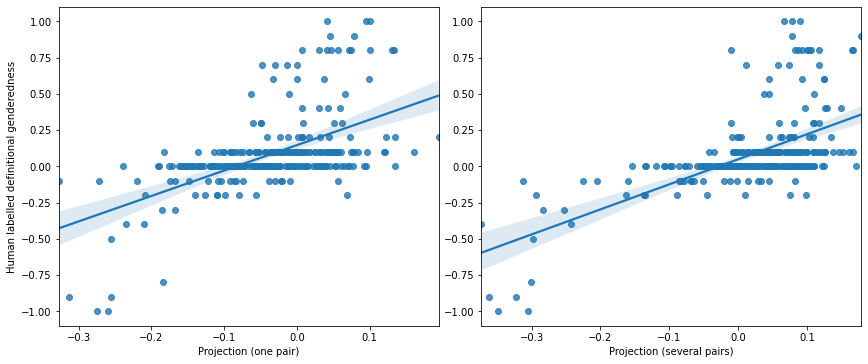

In [13]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
definitionality = [professions[title]['definitional'] for title in titles]
sns.regplot(x=projection, y=definitionality, ax=ax[0])
a = sns.regplot(x=projection2, y=definitionality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled definitional genderedness")
fig.tight_layout(pad=.5)
fig.show()

## More analogies


In [14]:
assert len(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == 2
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == list
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])[0]) == tuple

analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])

[('actor', 'actress'), ('actress', 'actor')]

In [15]:
analyzer.analogies(analogy_direction=direction2, tokens=titles)

[('accountant', 'businesswoman'),
 ('actor', 'actress'),
 ('actress', 'waitress'),
 ('administrator', 'bureaucrat'),
 ('adventurer', 'protagonist'),
 ('advocate', 'campaigner'),
 ('aide', 'counselor'),
 ('alderman', 'solicitor'),
 ('alter_ego', 'fashion_designer'),
 ('ambassador', 'secretary'),
 ('analyst', 'columnist'),
 ('anthropologist', 'pediatrician'),
 ('archaeologist', 'anthropologist'),
 ('archbishop', 'parishioner'),
 ('architect', 'painter'),
 ('artist', 'singer'),
 ('artiste', 'performer'),
 ('assassin', 'bodyguard'),
 ('astronomer', 'archaeologist'),
 ('athlete', 'swimmer'),
 ('attorney', 'paralegal'),
 ('author', 'novelist'),
 ('ballerina', 'actress'),
 ('banker', 'businesswoman'),
 ('barber', 'hairdresser'),
 ('barrister', 'campaigner'),
 ('bartender', 'waitress'),
 ('biologist', 'pediatrician'),
 ('bishop', 'parishioner'),
 ('bookkeeper', 'waitress'),
 ('boss', 'bartender'),
 ('boxer', 'wrestler'),
 ('broadcaster', 'columnist'),
 ('broker', 'realtor'),
 ('businessman', '